In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math

In [2]:
# Get data for a given ticker
ticker = "AAPL"
data = yf.Ticker(ticker).history("5y")

In [3]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-12-26 00:00:00-05:00,40.603416,40.762691,40.337162,40.548740,132742000,0.0,0.0
2017-12-27 00:00:00-05:00,40.437004,40.598655,40.344291,40.555866,85992800,0.0,0.0
2017-12-28 00:00:00-05:00,40.650964,40.853032,40.527346,40.669983,65920800,0.0,0.0
2017-12-29 00:00:00-05:00,40.536861,40.553500,40.227818,40.230194,103999600,0.0,0.0
2018-01-02 00:00:00-05:00,40.451280,40.960012,40.237326,40.950500,102223600,0.0,0.0


In [4]:
# calculate shot and long term moving average 
short_day = 20
long_day = 100
data["SMA"] = data["Open"].rolling(window = short_day).mean()
data["LMA"] = data["Open"].rolling(window = long_day).mean()

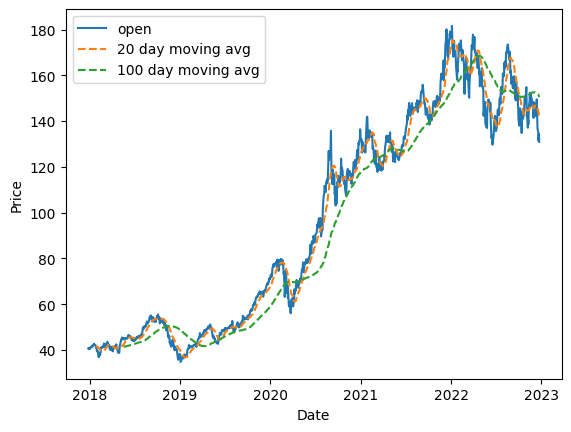

In [5]:
plt.plot(data["Open"], label = "open")
plt.plot(data["SMA"], ls = '--', label = "{} day moving avg".format(short_day))
plt.plot(data["LMA"], ls = '--', label = "{} day moving avg".format(long_day))
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [6]:
# initialise position and capital
starting_capital = 1000
data["Capital"] = starting_capital
data["Profit"] = 0
data["risk_free_return"] = starting_capital
data["shares_held"] = 0

# Simple Moving Average Crossover
We execture a simple moving average crossover strategy.  
When the SMA moves above the LMA and we aren't holding a stock we buy as much as possible.  
When the LMA moves above the SMA and we are holding a stock we sell as much as possible.  
If there is no crossover we continue doing as usual.  
We have accounted for the transaction fee as a percentage.  
  
We will also calculate the risk free rate and return on buying and holding as benchmarks.  

In [13]:
trading_fee = 0.005 # trading fee as a percentage
risk_free_rate = 0.05

# loop over days and initalise the strategy
for t, row in data.iterrows():

    # skip the first day
    if t == data.index[0]: 
        prev_row = row
        continue

    # calculate risk free return on capital
    data.loc[t, "risk_free_return"] = prev_row["risk_free_return"] * (1+risk_free_rate/365)

    # if short term average goes above the long term average and we arent holding a stock
    # buy all shares
    if(row["SMA"] > row["LMA"] and prev_row["shares_held"] == 0):
        capital_yesturday = prev_row['Capital']
        data.loc[t, "shares_held"] = math.floor(capital_yesturday/row['Close']) 
        data.loc[t, "Capital"] = capital_yesturday - row["shares_held"] * row['Close'] * (1 + trading_fee)
        buy = row["shares_held"] * row['Close'] * (1 + trading_fee)

    # if long term average goes above the short term average and we are holding a stock
    # sell all shares
    elif(row["LMA"] > row["SMA"] and prev_row["shares_held"] != 0):
        capital_yesturday = prev_row['Capital']
        data.loc[t, "Capital"] = capital_yesturday + row["shares_held"] * row['Close'] * (1 - trading_fee)
        sell = row["shares_held"] * row['Close'] * (1 - trading_fee)
        data.loc[t, "Profit"] += (sell - buy)
        data.loc[t, "shares_held"] = 0

    # no crossover so do nothing
    else:
        data.loc[t, "Capital"] = prev_row["Capital"]
        data.loc[t, "shares_held"] = prev_row["shares_held"]

    prev_row = row

# find the cummulative profit
data["cum_profit"] = data["Profit"].cumsum()

Lets plot the results of this strategy.

<AxesSubplot: xlabel='Date', ylabel='Profit'>

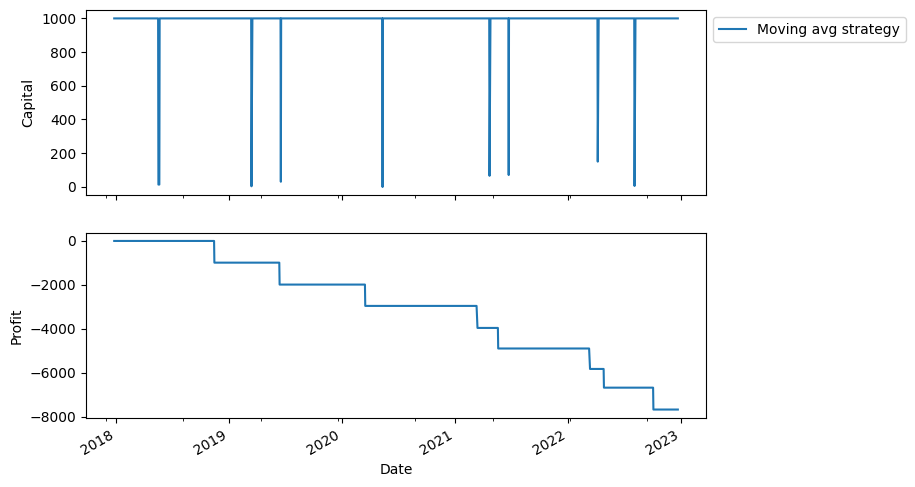

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# capital subplot
ax1.set_ylabel("Capital")
data.plot(y = "Capital", ax=ax1, label = "Moving avg strategy")
#data.plot(y = "risk_free_return", ax = ax1, label = "Risk free")
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# profit subplot
ax2.set_ylabel("Profit")
data.plot(y= "cum_profit", ax=ax2, legend = False)

## Short-selling

Lets add code to include short selling and see if we can make more money.

## Factoring in risk
Now we look to 